<div style="
    display: flex;
    justify-content: center;
    align-items: center;
">
    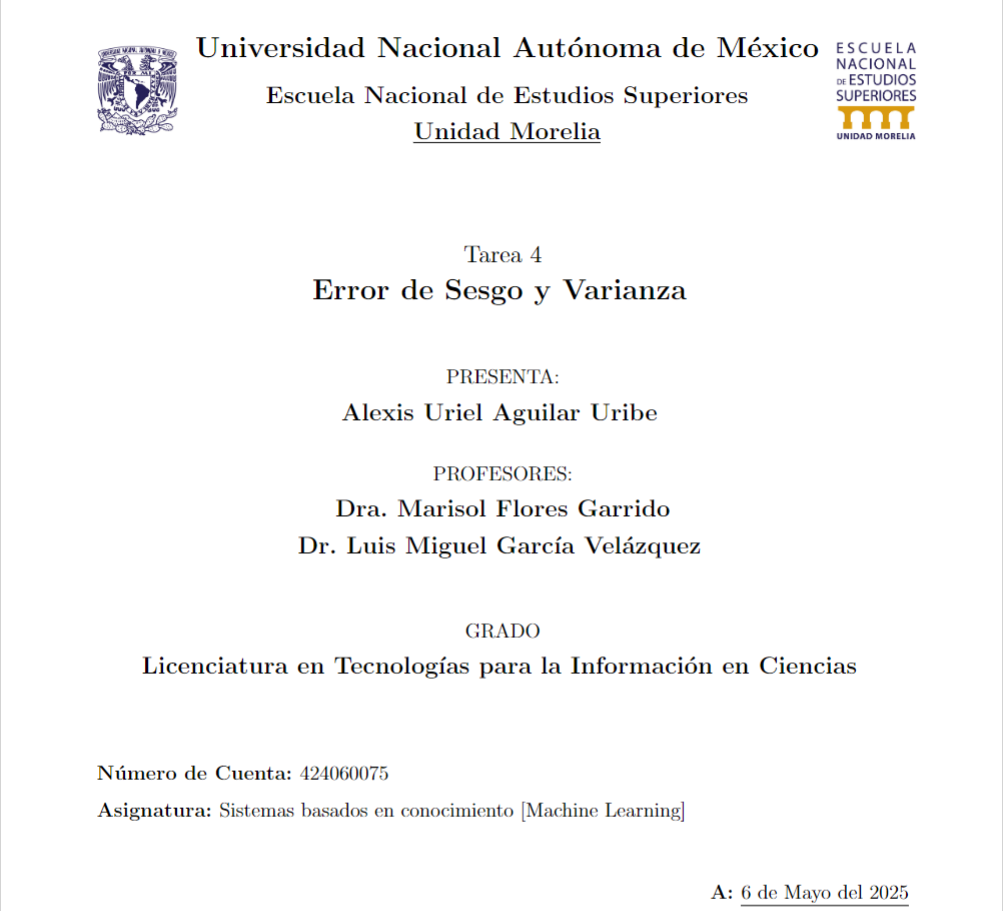
</div>

# Introducción

En el presente proyecto lo que se realiza es estudiar el balance entre sesgo y varianza, relacionado al overfit y underfit, que presentan los modelos al variar los hiperparámetros más relevantes en los modelos de Regresión Logística, K-Vecinos Más Cercanos y Árbol de Decisión. Este análisis se realizando de aprovechar las curvas de validación al ver cómo fluctúan los puntajes (scores) que se reportan en los conjuntos de entrenamiento y de validación sobre las predicciones del modelo con alguna métrica. Lo anterior con el enfoque de predecir la clase presente en el conjunto de datos [[2]](#referencias) sobre enfermedades hepáticas.

Primero se realiza la parte relacionada al Análisis Exploratorio de Datos (EDA) para encontrar posibles relaciones entre distribuciones, características que podrían ser de utilidad para determinar el comportamiento esperado de los modelos así como también la posibilidad de que de las clases sean linealmente separables o que exista una transformación en los atributos que favorezca nueva información o relaciones en los atributos. Para esto último se presenta un análisis univariado y bivariado.

Y por último se encuentra tanto la definición, ajuste de hiperparámetros, selección y validación de los modelos que se considerando para predecir el target en el conjunto de datos, esta cadena de procesos se realiza en base a las observaciones y consideraciones generadas a partir de las curvas de validación que se generan por cada modelo usando un rango apropiado de hiperparámetros. En donde también se define de forma implícita un criterio para la selección del mejor modelo al considerar los scores reportados.

Este proyecto se encuentra disponible en: [Liver Patient Model](https://github.com/alexisuaguilaru/Liver_Patient_Model)

# 0. Importar Librerías y Otro Código

Para este proyecto se está usando Python ``3.12.5`` con las librerías:

* pandas == 2.2.3
* numpy == 2.2.4
* seaborn == 0.13.2
* matplotlib == 3.10.1
* scikit-learn == 1.6.1

In [6]:
# Import libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from os import cpu_count
from math import  sqrt , floor

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [7]:
# Relevant variables

Features = ['age','gender','tot_bilirubin','direct_bilirubin','alkphos','sgpt','sgot','tot_proteins','albumin','ag_ratio']
Target = 'is_patient'

In [8]:
# Auxiliar variables

COLOR = '#7C92A0'
COLOR_PALETTE = ['#F5AE47','#47AAF5']

RANDOM_STATE = 8013
NUM_JOBS = floor(sqrt(cpu_count()))

## 0.1 Definición de Funciones Útiles

In [9]:
def SplitFeaturesUsingDatatype(Dataset:pd.DataFrame,Features:list[str]):
    continuous , integer , categorical = [] , [] , []
    
    for feature in Features:
        if (data_type:=Dataset[feature].dtype) == 'float':
            continuous.append(feature)
        elif data_type == 'int':
            integer.append(feature)
        else:
            categorical.append(feature)
    
    return continuous , integer , categorical

In [10]:
def PlotFeaturesDistribution(Dataset:pd.DataFrame,Features:list[str],NameFeature:str):
    n_features = len(Features)
    fig , axes = plt.subplots(n_features,2,figsize=(12,4*n_features),layout='tight')

    for index , feature in enumerate(Features):
        sns.boxplot(Dataset,x=feature,y='gender',hue='is_patient',ax=axes[index,0],palette=COLOR_PALETTE)
        sns.histplot(Dataset,x=feature,ax=axes[index,1],stat='proportion',color=COLOR)

    fig.suptitle(f'Distribución de Atributos {NameFeature}',size=24)

In [11]:
def PlotCorrelogram(Dataset:pd.DataFrame,Features:list[str]):
    fig , axes = plt.subplots(figsize=(9,8),layout='tight')
    correlation = Dataset[Features].corr()
    
    sns.heatmap(correlation,vmin=-1,vmax=1,annot=True,cmap='coolwarm',ax=axes)
    fig.suptitle('Correlación entre Atributos Numéricos',size=24)

In [39]:
def PlotPrincipalComponents(PrincipalComponents:np.ndarray,MainComponent:int):
    fig , axes = plt.subplots(4,2,figsize=(12,16))

    for axe , minor_component in zip(axes.ravel(),[minor_component for minor_component in range(PrincipalComponents.shape[1]) if minor_component != MainComponent]):
        sns.scatterplot(x=PrincipalComponents[:,MainComponent],y=PrincipalComponents[:,minor_component],ax=axe,hue=LiverDataset[Target],palette=COLOR_PALETTE)
        axe.set_xlabel(f'PC{MainComponent+1}')
        axe.set_ylabel(f'PC{minor_component+1}')

    fig.suptitle(f'Componente Principal {MainComponent+1}\ncontra las demás Componentes Principales',size=24)

In [13]:
def PlotValidationCurve(Model:str):
    global_vars = globals()
    
    train_scores , test_scores = global_vars[f'ValidationCurve_{Model}']
    parameter_name = global_vars[f'Parameter_{Model}']
    parameter_range = global_vars[f'ParameterRange_{Model}']

    fig , axes = plt.subplots(figsize=(8,6))
    axes.plot(parameter_range,train_scores.mean(axis=1),label='Train Scores',c=COLOR_PALETTE[0],ls=':',marker='v')
    axes.plot(parameter_range,test_scores.mean(axis=1),label='Test Scores',c=COLOR_PALETTE[1],ls='--',marker='^')

    axes.set_xlabel(f'Valores de {parameter_name[12:]}',size=12)
    axes.set_ylabel('Puntaje de Recall (Sensibilidad)',size=12)
    axes.set_ylim(0.5,1+1e-2)
    axes.tick_params(labelsize=10)
    axes.legend(loc=4)

    fig.suptitle(f'Curva de Validación para {Model}',size=18)

In [65]:
from sklearn.metrics import recall_score

def EvaluateModels(Models:list[str],Set_X:np.ndarray,Set_y:np.ndarray,NameSets:str):
    print(f'Evaluaciones en el Conjunto de {NameSets}\n')

    global_vars = globals()
    for model in Models:
        print(f'Evluación de {model} ::')
        y_pred = global_vars[f'Model_{model}'].predict(Set_X)
        print(f'Sensibilidad (Recall) :: {recall_score(Set_y,y_pred,pos_label='Yes')}\n')

# 1. Carga del Conjunto de Datos y Primera Exploración

Se realiza la carga del conjunto de datos así como el renombramiento de las columnas para que coincida con los nombres que están en los requisitos [[1]](#referencias). Después de ello, se explorar el conjunto de datos de forma básica para encontrar los valores faltantes y los tipos de datos incorrectos.

Sobre los valores faltantes, se tiene que hay 4 en el atributo ``ag_ratio``. Adicional a esto, los valores del target (``is_patient``) se transformaron para que sigan una notación más legible.

In [18]:
# Carga del Conjunto de Datos

LiverDataset = pd.read_csv('IndianLiverPatientDataset.csv',index_col=None,header=None)

# Renombrar columnas

attributes_names = dict(zip(range(11),Features+[Target]))
LiverDataset.rename(columns=attributes_names,inplace=True)

LiverDataset.head(5)

,age,gender,tot_bilirubin,direct_bilirubin,alkphos,sgpt,sgot,tot_proteins,albumin,ag_ratio,is_patient
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


El conjunto de datos cuenta con valores faltantes en ``ag_ratio`` y los tipos de datos coinciden con la descripción dada en [[2]](#referencias)

In [19]:
# Exploración de valores faltantes y tipos de datos

LiverDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               583 non-null    int64  
 1   gender            583 non-null    object 
 2   tot_bilirubin     583 non-null    float64
 3   direct_bilirubin  583 non-null    float64
 4   alkphos           583 non-null    int64  
 5   sgpt              583 non-null    int64  
 6   sgot              583 non-null    int64  
 7   tot_proteins      583 non-null    float64
 8   albumin           583 non-null    float64
 9   ag_ratio          579 non-null    float64
 10  is_patient        583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


Como los valores que toma ``is_patient`` no son los típicos valores de ``1`` o ``0`` o de ``Yes`` o ``No``, se tiene que al contar los valores del target se puede determinar cuál valor corresponde con la clase positiva del target. Y con ello, transformar los valores en ``Yes`` y ``No``.

In [ ]:
# Explorando los valores del target

print('Valores de `is_patient` :: ',LiverDataset.is_patient.unique())

LiverDataset.groupby(Target).size()

Values of `is_patient` ::  [1 2]


is_patient
1    416
2    167
dtype: int64

Por [[2]](#referencias) se sabe que el conjunto de datos contiene ``416`` registros de pacientes diagnostica con alguna enfermedad hepática y los restantes ``167`` sin ella, por lo que el valor de ``1`` corresponde a ``Yes`` y los valores con ``2`` a ``No``

In [ ]:
# Transformación de los valores del target

target_values = np.array(['No','Yes'])

LiverDataset.is_patient = (target_values[LiverDataset.is_patient%2])

LiverDataset.groupby(Target).size()

is_patient
No     167
Yes    416
dtype: int64

# 2. Valores Faltantes

Como solo hay 4 instancias que tienen valores faltantes en ``ag_ratio`` y son 2 de cada clase, se pueden eliminar sin generar una perdida notoria de instancias de entrenamiento.

In [23]:
# Eliminando instancias con valores faltantes

LiverDataset.query("ag_ratio == ag_ratio",inplace=True)

LiverDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 579 entries, 0 to 582
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               579 non-null    int64  
 1   gender            579 non-null    object 
 2   tot_bilirubin     579 non-null    float64
 3   direct_bilirubin  579 non-null    float64
 4   alkphos           579 non-null    int64  
 5   sgpt              579 non-null    int64  
 6   sgot              579 non-null    int64  
 7   tot_proteins      579 non-null    float64
 8   albumin           579 non-null    float64
 9   ag_ratio          579 non-null    float64
 10  is_patient        579 non-null    object 
dtypes: float64(5), int64(4), object(2)
memory usage: 54.3+ KB


# 3. Data Analysis

Del análisis de loos atributos se puede observara que no existe una forma simple (lineal) de separar las clases debido a un solapamiento en los box plots así como se genera cuando se gráfica los componentes principales, lo anterior implica que se vuelve necesario el usar modelos que creen bordes de decisión no lineales o generar atributos derivados de procesos no lineales. 

Como los atributos numéricos siguen distribuciones que se generan o provienen de procesos con distribuciones normales (como la distribución t de Student, $\chi^2$ o la propia normal), se vuelve interesante que el proceso de tener una enfermedad hepática provengan de una interacción compleja y no lineal entre varios procesos y factores que siguen distribuciones normales.

Adicional a lo anterior, se tiene que estas interacciones (que se están considerando en el conjunto de datos, mientras que otras se omiten), por su naturaleza, causen que varios de los atributos se encuentren correlacionados, por lo que varios de estos atributos se vuelven irrelevantes o repetidos respecto la información que podrían contribuir para el diagnostico de un paciente.

In [24]:
# Separación de los atributos en base a su tipo de datos

ContinuousFeatures , IntegerFeatures , CategoricalFeatures = SplitFeaturesUsingDatatype(LiverDataset,Features)

## 3.1 Distribución de Atributos

Dado que el género desempeña un papel importante en el proceso de enfermedad de un paciente, debe tenerse en cuenta al momento de estudiar los datos para conocer cómo se modifica la distribución tanto por ``gender`` como por ``is_patient``.

Se destaca que existe un desequilibrio en la distribución de ``gender`` debido a que el valor ``Female`` tiene una baja representatividad en ambas clases en contraste con el valor ``Male``, esto tendrá implicaciones al momento de entrenar el modelo debido a que no contará con suficientes instancias de estas cualidades para encontrar un patrón al momento de generar la clasificación.

Utilizando los box plots, se puede determinar que algunos atributos reportan una cantidad razonable de valores atípicos, es decir, una cantidad que podría obviarse; en cambio, en otras características sucede lo contrario, pues tienen demasiados outliers, y esto se debe al rango de valores que toman, para reducir el impacto de este rango lo que se puede hacer es aplicar una función como ``sqrt`` o ``log10`` para compactar el rango de manera no lineal.

Al transformar los atributos ``tot_bilirrubin``, ``direct_bilirrubin``, ``alkphos``, ``sgpt`` y ``sgot`` con ``log10``, el impacto de los outliers se redujo considerablemente en el sentido de que sus cantidades pueden considerarse normales y, en algunos casos, se pueden ignorar y considerarse para el conjunto de datos limpio. Por ello, no se eliminarán outliers debido a que sería contraproducente destacar varias instancias o modificar su comportamiento al imputar los outliers.

Considerando los histogramas, se puede observar que siguen una tendencia de una distribución normal, t de Student o $\chi^2$ (estos dos últimos tienen un cierto comportamiento normal o surgen de estas distribuciones), con esto muchos de los algoritmos de Machine Learning van a obtener los mejores resultados posibles o encontrar patrones de una mejor manera.

Considerando los box plots, se puede observar que hay un solapamiento, esto significaría que no hay diferencias significativas en las medias y medianas de las distribuciones, lo que equivale a que el modelo tendrá dificultades para aprender a diferenciar entre clases porque muchos de los valores que toman los atributos son compartidos en ambas clases. A partir de ello, puede haber dos pacientes que tengan los mismos indicadores clínicos, pero uno padezca de una enfermedad hepática y el otro no.

In [25]:
# Distribución de Género

LiverDataset.pivot_table('age',CategoricalFeatures[0],Target,'count')

is_patient,No,Yes
gender,,
Female,49,91
Male,116,323


### 3.1.1 Distribución de Atributos Continuos

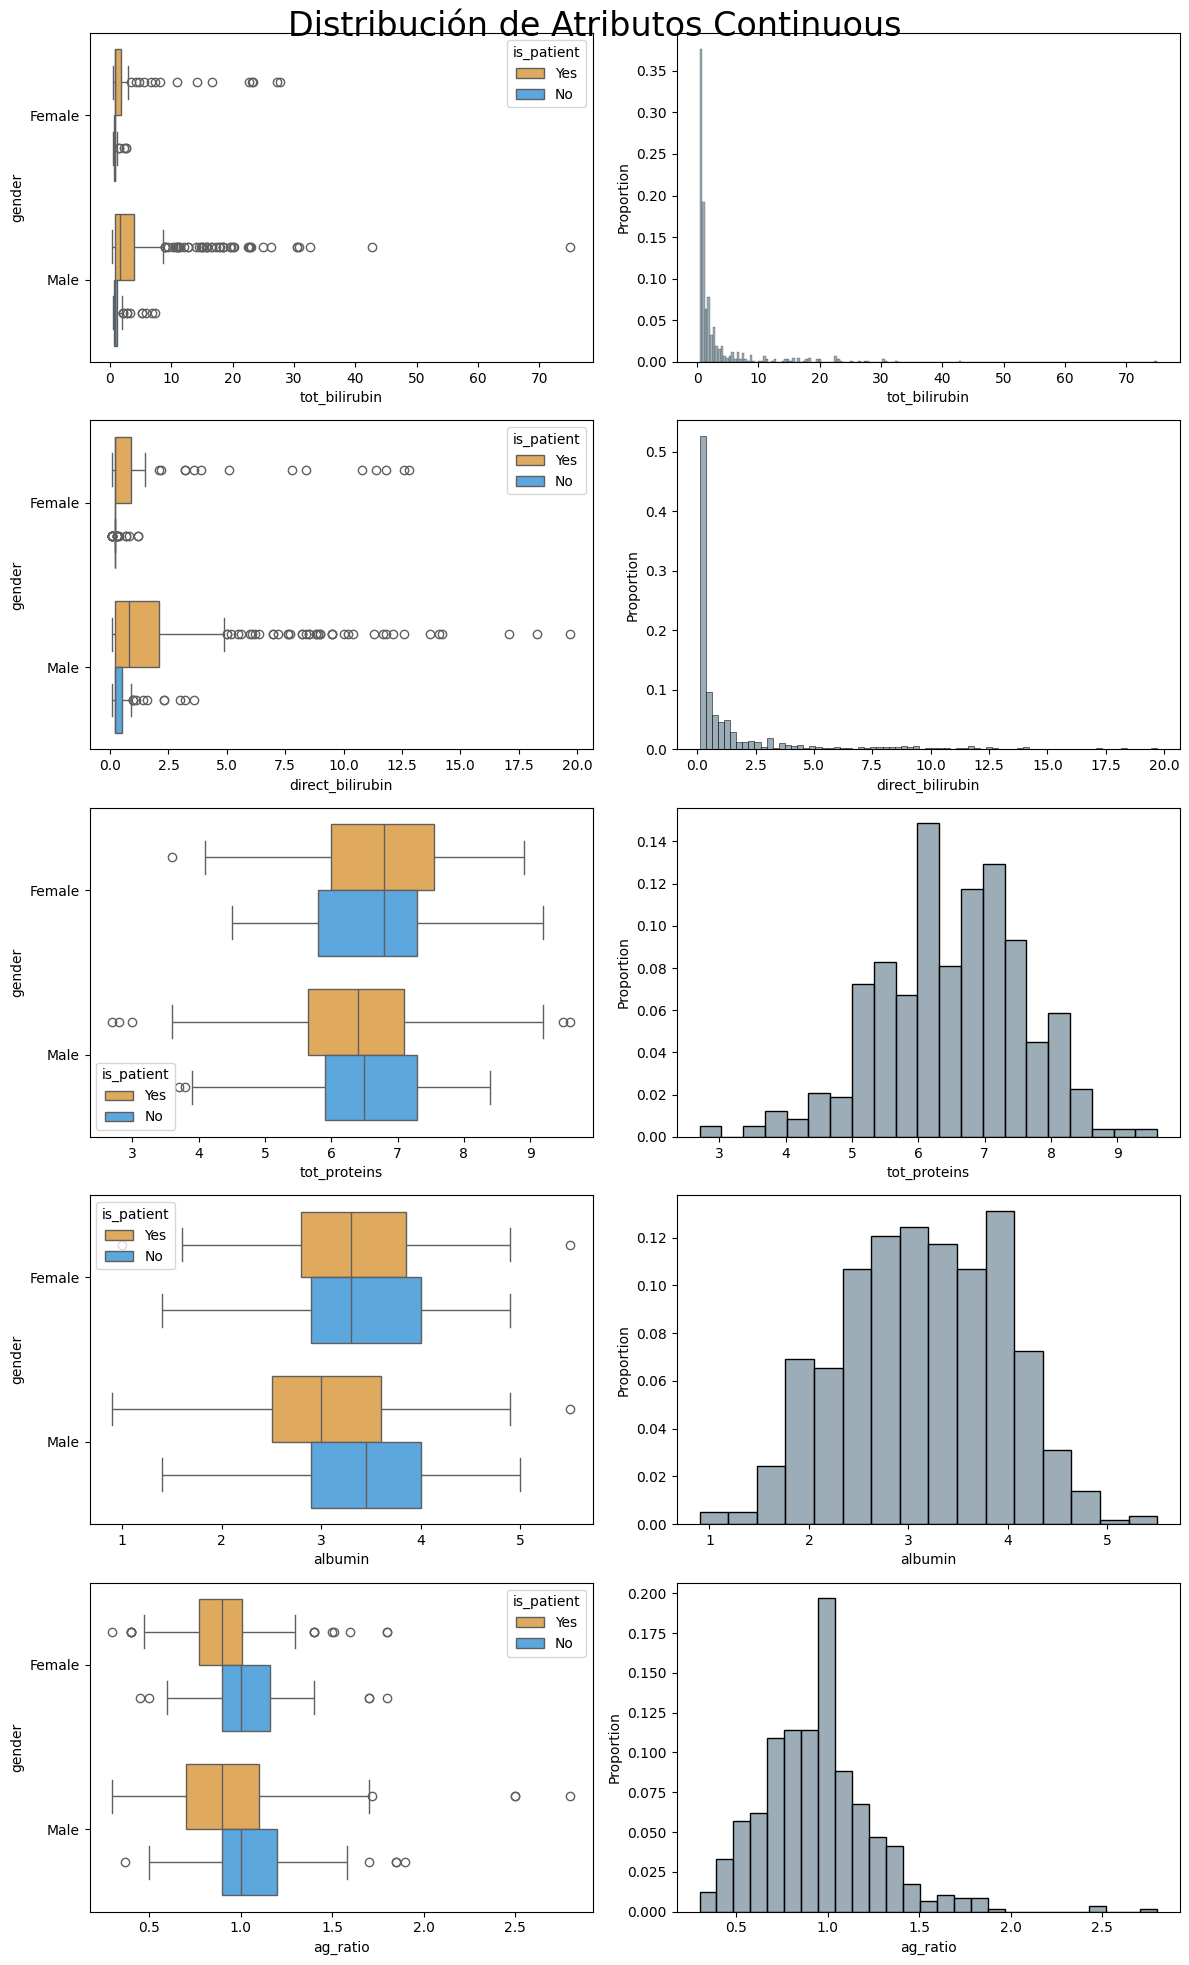

In [26]:
PlotFeaturesDistribution(LiverDataset,ContinuousFeatures,'Continuous')

### 3.1.2 Distribución de Atributos Enteros

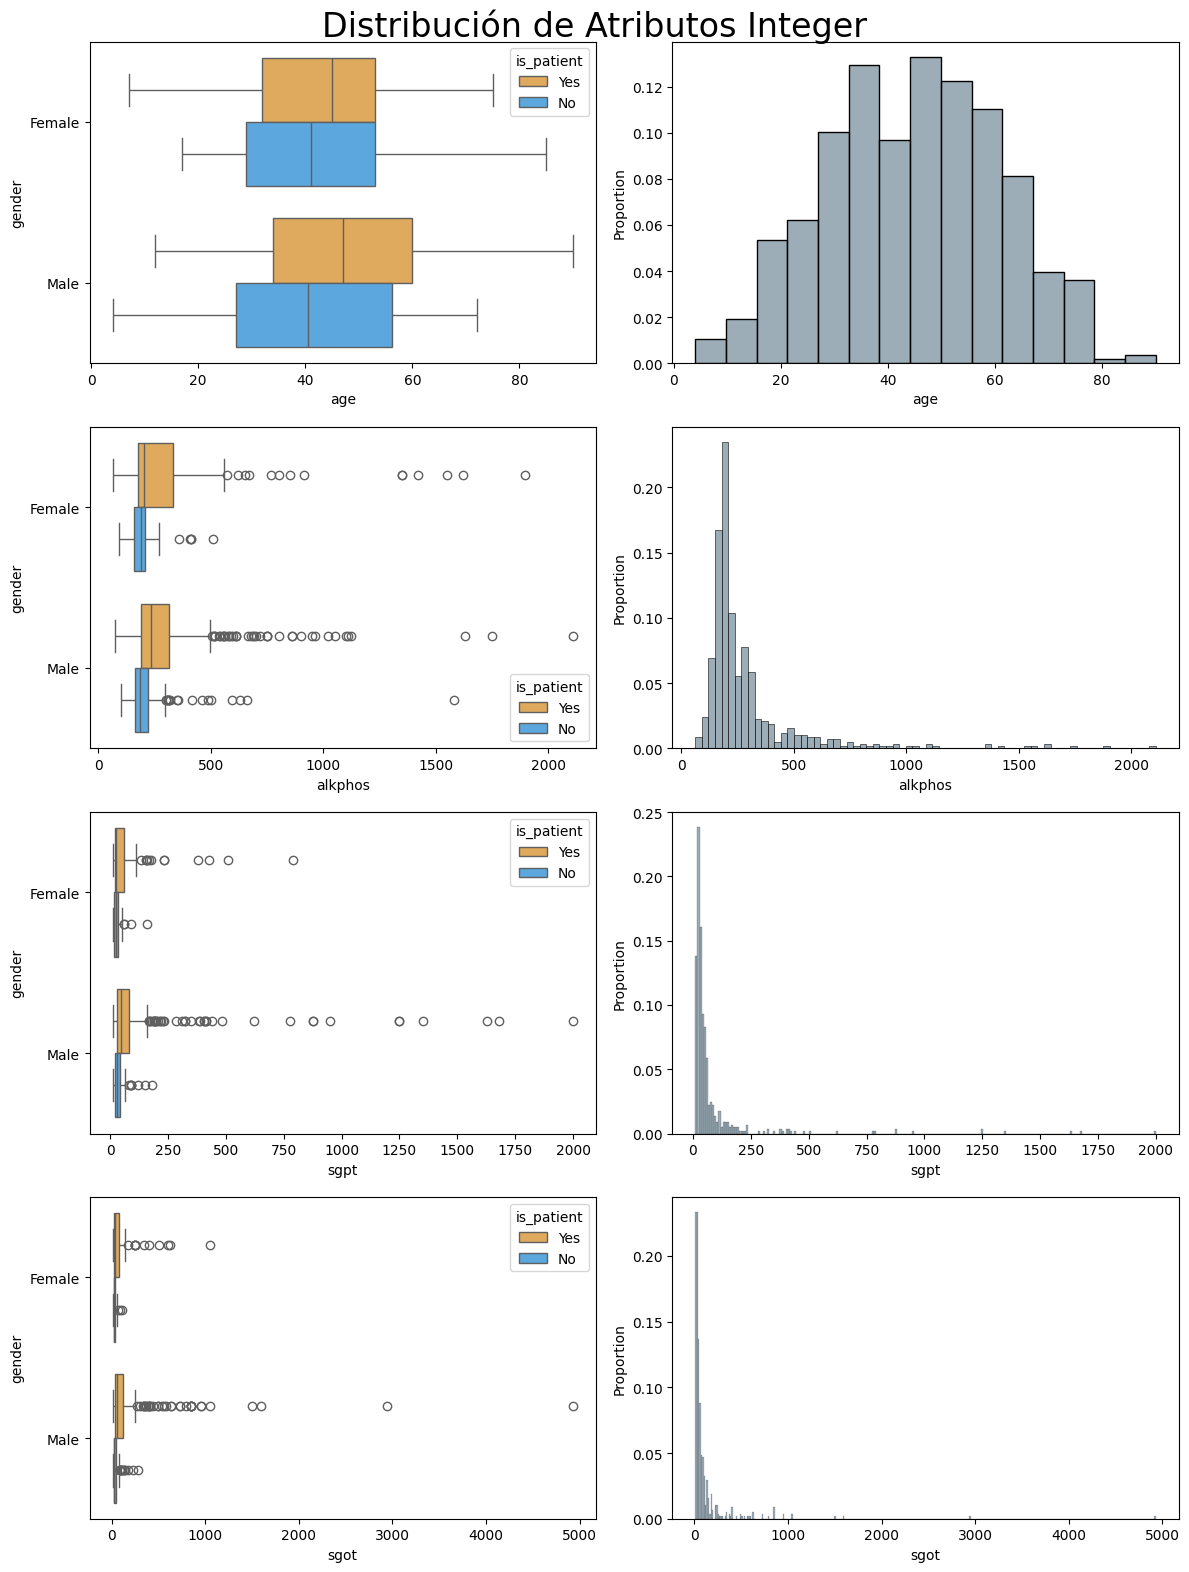

In [27]:
PlotFeaturesDistribution(LiverDataset,IntegerFeatures,'Integer')

### 3.1.3 Transformación No Lineal de Atributos

In [29]:
# Aplicando la transformación Log_10

LiverDataset_copy = LiverDataset.copy()

features_transformation = [*ContinuousFeatures[:2],*IntegerFeatures[1:]]

for feature in features_transformation:
    LiverDataset_copy[feature] = np.log10(LiverDataset[feature])

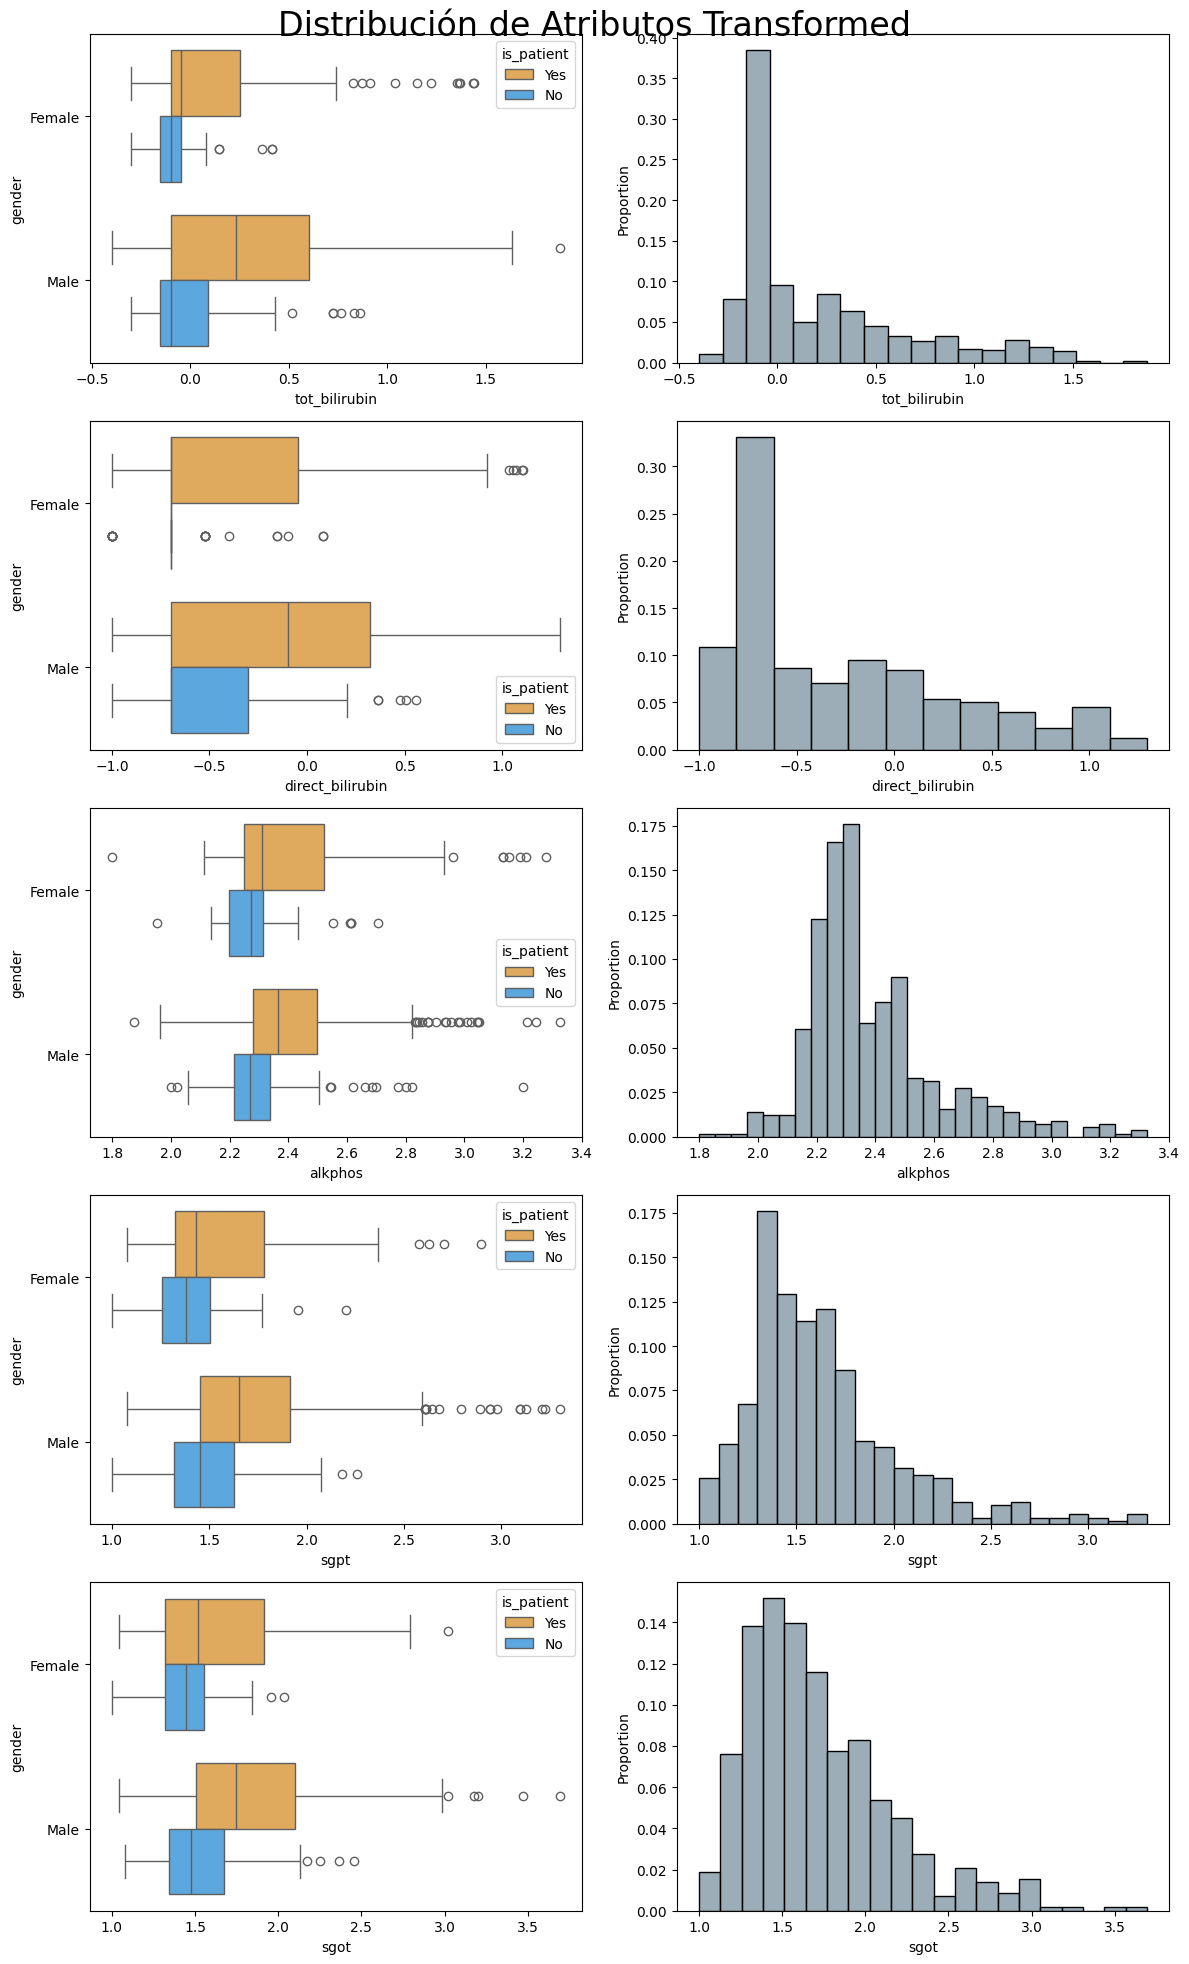

In [31]:
PlotFeaturesDistribution(LiverDataset_copy,features_transformation,'Transformed')

## 3.2 Análisis Bivariado

Del correlograma se observa que muchas de las variables están en relaciones lineales, por lo que hay información que se vuelve redundante a la hora de hacer la predicción o entender las diferentes relaciones. Por lo tanto, las variables podrían reducirse mediante el uso del Análisis de Componentes Principales (PCA). El único problema de esta reducción es que podrían perderse las relaciones no lineales en el espacio original, por lo que resulta más relevante mantener tanto los atributos originales como los transformados mediante PCA.

Realizando la transformación de los atributos numéricos mediante PCA, se encuentra que los primeros tres componentes explican aproximadamente el ``99.8%`` de la varianza de los datos, es decir, utilizando estos componentes principales es posible conservar las relaciones lineales de los atributos originales además de preservar parte de la información que tenían originalmente. 

Utilizando scatter plots de los valores de los componentes principales de cada instancia, se puede observar que utilizando los primeros tres componentes frente a todos los demás se puede observar como los datos comienzan a agruparse según su valor de ``is_patient``, esto podría estar relacionado con que las relaciones no lineales podrían ser preservadas o capturadas con PCA. En concreto, se puede observar que utilizando los primeros cuatro componentes, se generan grupos según el valor del target o se empiezan a agrupar debido a la pérdida de variabilidad explicada.  

Por último, estos grupos que se generan están solapados, lo que indica que no son linealmente separables, por lo que sería conveniente que el modelo de clasificación aprovechara transformaciones no lineales para generar la separación entre grupos, como por ejemplo utilizando modelos como SVM o Random Forest.

### 3.2.1 Correolograma

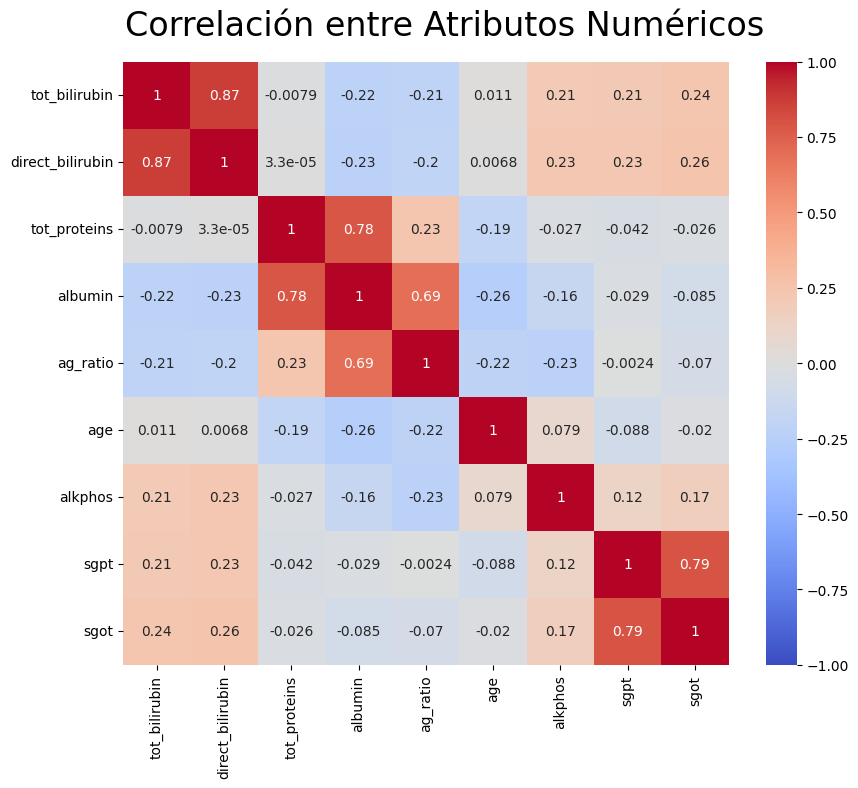

In [34]:
PlotCorrelogram(LiverDataset,ContinuousFeatures+IntegerFeatures)

### 3.2.2 Análisis de Componentes Principales (PCA)

In [37]:
PCA_Model = PCA(whiten=True,random_state=RANDOM_STATE)
Principal_Component = PCA_Model.fit_transform(LiverDataset_copy[ContinuousFeatures+IntegerFeatures])

print('Ratio de Varianza Explicada')
for principal_component , variance_ratio in enumerate(PCA_Model.explained_variance_ratio_):
    print(f'PC{principal_component+1}: {variance_ratio:.4f}')

Ratio de Varianza Explicada
PC1: 0.9897
PC2: 0.0059
PC3: 0.0025
PC4: 0.0008
PC5: 0.0006
PC6: 0.0002
PC7: 0.0001
PC8: 0.0001
PC9: 0.0000


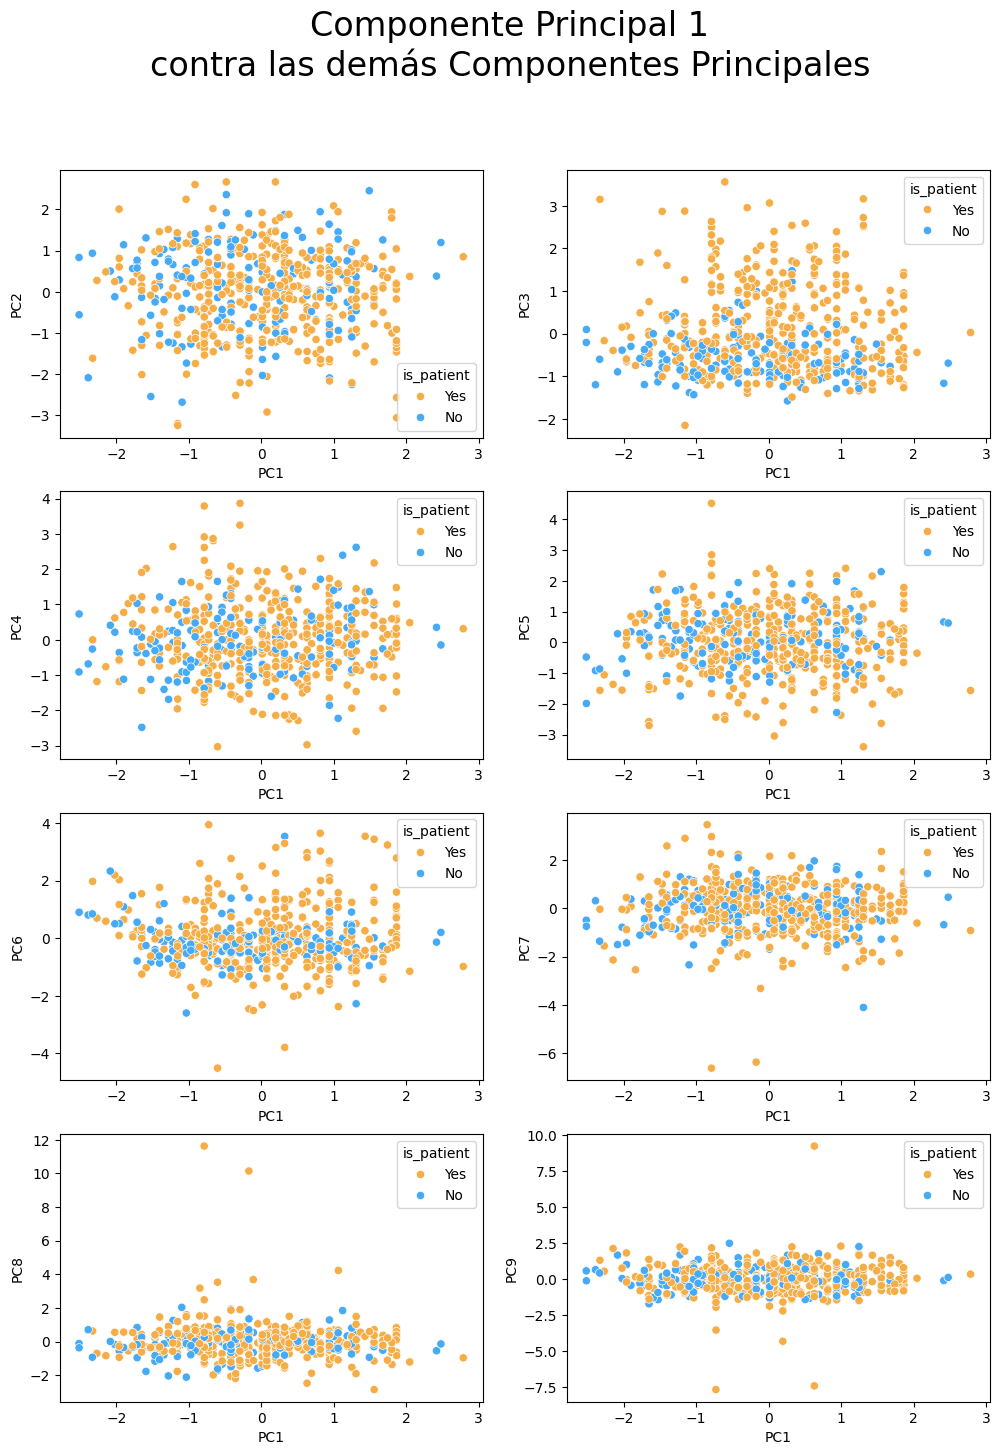

In [40]:
PlotPrincipalComponents(Principal_Component,0)

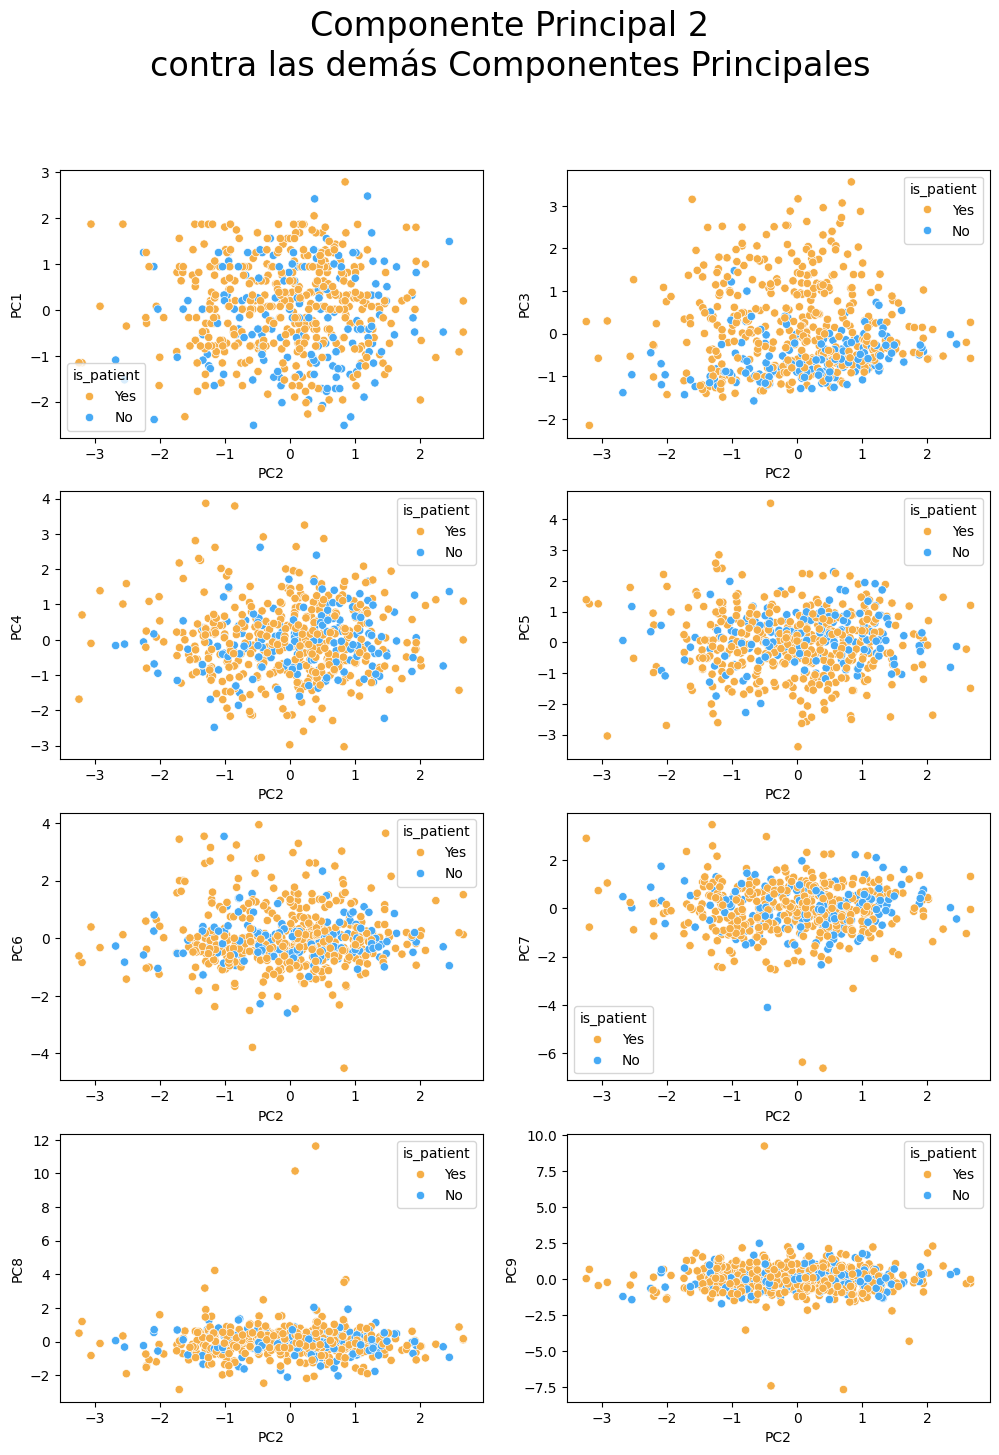

In [41]:
PlotPrincipalComponents(Principal_Component,1)

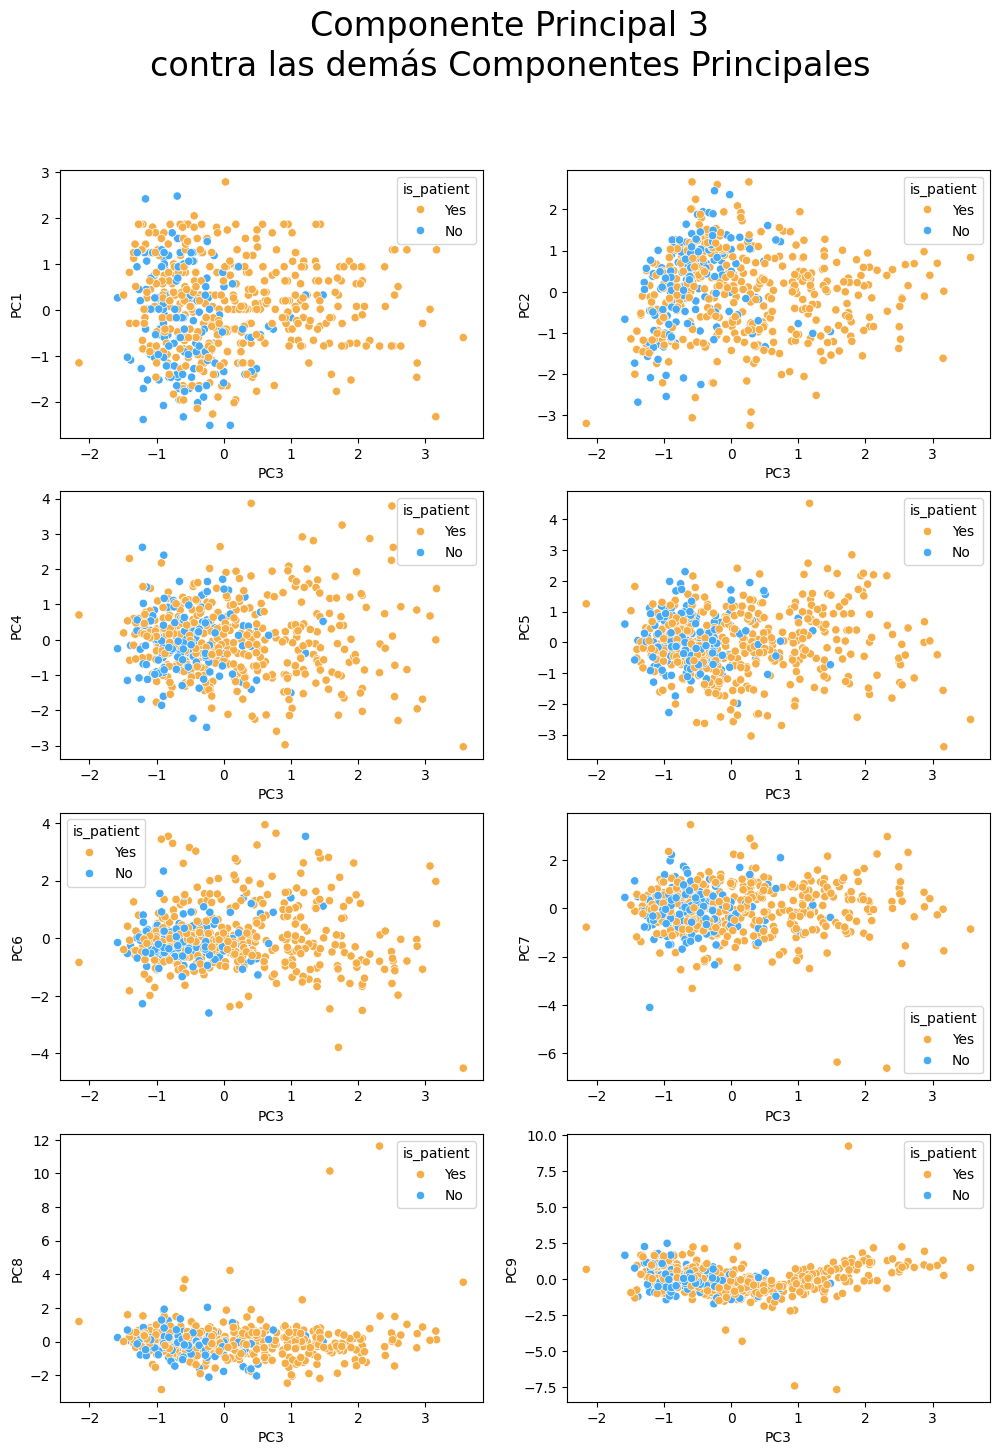

In [42]:
PlotPrincipalComponents(Principal_Component,2)

# 4. Pipeline de Preprocesamiento

En referencia a los insights adquiridos en [Data Analysis](#3-data-analysis), algunos de los atributos numéricos se transforman con la función ``log10`` para transformar su distribución y hacer que la información de estos valores transformados sea más relevante para el modelo. Dado que los modelos que se crean, basados en [[1]](#referencias) algunos de ellos se basan en la distancia, se aplica un escalado estándar para obtener los valores bajo el mismo rango y medida.

In [43]:
# Importar librerías

from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import FunctionTransformer , OrdinalEncoder , StandardScaler
from sklearn.decomposition import PCA

In [45]:
# Definición de preprocesamiento por atributo

PreprocessingFeatures = ColumnTransformer(
    [
        ('NumericalFeaturesTransformation',FunctionTransformer(np.log10,lambda value : np.pow(10,value)),[*ContinuousFeatures[:2],*IntegerFeatures[1:]]),
        ('CategoricalFeaturesEncode',OrdinalEncoder(),CategoricalFeatures),
    ], remainder='passthrough', n_jobs=NUM_JOBS,force_int_remainder_cols=False
)

In [46]:
# Atributos adicionales por PCA

AdditionalFeatures = FeatureUnion(
    [
        ('PCA',PCA(n_components=5,random_state=RANDOM_STATE)),
        ('WithoutChanges','passthrough'),
    ], n_jobs=NUM_JOBS
)

In [47]:
# Definición de pipeline de preprocesamiento

PreprocessingPipeline = Pipeline(
    [
        ('PreprocessingFeatures',PreprocessingFeatures),
        ('GeneratingFeatures',AdditionalFeatures),
        ('Scaling',StandardScaler()),
    ]
)

PreprocessingPipeline

Pipeline(steps=[('PreprocessingFeatures',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=4,
                                   remainder='passthrough',
                                   transformers=[('NumericalFeaturesTransformation',
                                                  FunctionTransformer(func=<ufunc 'log10'>,
                                                                      inverse_func=<function <lambda> at 0x0000013B4DA013A0>),
                                                  ['tot_bilirubin',
                                                   'direct_bilirubin',
                                                   'alkphos', 'sgpt', 'sgot']),
                                                 ('CategoricalFeaturesEncode',
                                                  OrdinalEncoder(),
                                                  ['gender'])])),
                ('GeneratingFeatures',
                 FeatureUnion(n_jobs=4,
                              transformer_list=[('PCA',
                                                 PCA(n_components=5,
                                                     random_state=8013)),
                                                ('WithoutChanges',
                                                 'passthrough')])),
                ('Scaling', StandardScaler())])

# 5. Definición de Modelos

Siguiendo los requisitos de [[1]](#referencias), se definen tres modelos basados en Logistic Regression, K Nearest Neighbors y Decision Tree donde se seleccionan los mejores modelos variando el factor de regularización ``C``, ``n_neighbors`` y ``max_depth`` respectivamente, dejando el resto de parámetros en sus valores por defecto ya que el interés radica en determinar cómo cambia el comportamiento de los modelos, la predicción, al variar los hiperparámetros más relevantes de los modelos y que controlan el bias-variance trade-off.

In [48]:
# Importar librarías

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [49]:
# Modelos definidos

Models = ['LogisticRegression','KNN','DecisionTree']

In [50]:
# Definición del modelo usando Logistic Regression

Model_LogisticRegression = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Classifier',LogisticRegression(random_state=RANDOM_STATE,n_jobs=NUM_JOBS)),
    ]
)
Parameter_LogisticRegression = 'Classifier__C'
ParameterRange_LogisticRegression = np.linspace(0,2,21)[1:]

Model_LogisticRegression

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('PreprocessingFeatures',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=4,
                                                    remainder='passthrough',
                                                    transformers=[('NumericalFeaturesTransformation',
                                                                   FunctionTransformer(func=<ufunc 'log10'>,
                                                                                       inverse_func=<function <lambda> at 0x0000013B4DA013A0>),
                                                                   ['tot_bilirubin',
                                                                    'direct_bilirubin',
                                                                    'alkphos',
                                                                    'sgpt',
                                                                    'sgot']),
                                                                  ('CategoricalFeaturesEncode',
                                                                   OrdinalEncoder(),
                                                                   ['gender'])])),
                                 ('GeneratingFeatures',
                                  FeatureUnion(n_jobs=4,
                                               transformer_list=[('PCA',
                                                                  PCA(n_components=5,
                                                                      random_state=8013)),
                                                                 ('WithoutChanges',
                                                                  'passthrough')])),
                                 ('Scaling', StandardScaler())])),
                ('Classifier',
                 LogisticRegression(n_jobs=4, random_state=8013))])

In [53]:
# Definición del modelo usando K Nearest Neighbors 

Model_KNN = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Classifier',KNeighborsClassifier(n_jobs=NUM_JOBS)),
    ]
)

Parameter_KNN = 'Classifier__n_neighbors'
ParameterRange_KNN = np.arange(1,25)

Model_KNN

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('PreprocessingFeatures',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=4,
                                                    remainder='passthrough',
                                                    transformers=[('NumericalFeaturesTransformation',
                                                                   FunctionTransformer(func=<ufunc 'log10'>,
                                                                                       inverse_func=<function <lambda> at 0x0000013B4DA013A0>),
                                                                   ['tot_bilirubin',
                                                                    'direct_bilirubin',
                                                                    'alkphos',
                                                                    'sgpt',
                                                                    'sgot']),
                                                                  ('CategoricalFeaturesEncode',
                                                                   OrdinalEncoder(),
                                                                   ['gender'])])),
                                 ('GeneratingFeatures',
                                  FeatureUnion(n_jobs=4,
                                               transformer_list=[('PCA',
                                                                  PCA(n_components=5,
                                                                      random_state=8013)),
                                                                 ('WithoutChanges',
                                                                  'passthrough')])),
                                 ('Scaling', StandardScaler())])),
                ('Classifier', KNeighborsClassifier(n_jobs=4))])

In [54]:
# Definición del modelo usando Decision Tree

Model_DecisionTree = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Classifier',DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
)

Parameter_DecisionTree = 'Classifier__max_depth'
ParameterRange_DecisionTree = np.arange(1,8)

Model_DecisionTree

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('PreprocessingFeatures',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=4,
                                                    remainder='passthrough',
                                                    transformers=[('NumericalFeaturesTransformation',
                                                                   FunctionTransformer(func=<ufunc 'log10'>,
                                                                                       inverse_func=<function <lambda> at 0x0000013B4DA013A0>),
                                                                   ['tot_bilirubin',
                                                                    'direct_bilirubin',
                                                                    'alkphos',
                                                                    'sgpt',
                                                                    'sgot']),
                                                                  ('CategoricalFeaturesEncode',
                                                                   OrdinalEncoder(),
                                                                   ['gender'])])),
                                 ('GeneratingFeatures',
                                  FeatureUnion(n_jobs=4,
                                               transformer_list=[('PCA',
                                                                  PCA(n_components=5,
                                                                      random_state=8013)),
                                                                 ('WithoutChanges',
                                                                  'passthrough')])),
                                 ('Scaling', StandardScaler())])),
                ('Classifier', DecisionTreeClassifier(random_state=8013))])

# 6. Models Fitting

De acuerdo con [[1]](#referencias), para el ajuste de hiperparámetros y el entrenamiento del modelo, se utilizarán ``10`` folds o grupos junto con una proporción del ``80%`` de los datos para el conjunto de entrenamiento y el ``20%`` restante para el conjunto de validación. De forma similar, se sigue este patrón para dividir el conjunto de datos original en las mismas proporciones para el conjunto de entrenamiento y el de pruebas.

Para determinar qué configuración de hiperparámetros es la más adecuada para cada modelo, se elige la métrica ``recall`` porque se desea reducir el impacto de los Falsos Negativos en el sentido de que dar a un paciente el diagnóstico de que no tiene una enfermedad hepática cuando sí la tiene es más agravante que decirle que sí la tiene y realizar más estudios para descartarla con mayor certeza; a esto se añade también el hecho de que el conjunto de datos no está balanceado, por lo que es conveniente utilizar una métrica distinta de ``accuracy``.

In [55]:
# Importar librarías

from sklearn.model_selection import train_test_split , ShuffleSplit , validation_curve
from sklearn.metrics import recall_score , make_scorer

In [56]:
# División del conjunto de datos en de entrenamiento y de prueba

train_X , test_X , train_y , test_y = train_test_split(LiverDataset[Features],LiverDataset[Target],test_size=0.2,random_state=RANDOM_STATE)

In [57]:
# Definición de recall score custom

RecallScore = make_scorer(recall_score,pos_label='Yes')

In [59]:
# Obteniendo las variables globales

global_vars = globals()

# Fitting de modelos

folds_cross_validation = ShuffleSplit(n_splits=10,test_size=0.2,random_state=RANDOM_STATE)

for model in Models:
    print(f'EMPIEZA FITTING DE :: {model}')
    
    model_estimator = global_vars[f'Model_{model}'] 
    parameter_name = global_vars[f'Parameter_{model}'] 
    parameter_range = global_vars[f'ParameterRange_{model}'] 
    
    validation_curve_model = validation_curve(model_estimator,train_X,train_y,
                                              param_name=parameter_name,param_range=parameter_range,
                                              cv=folds_cross_validation,scoring=RecallScore,
                                              n_jobs=NUM_JOBS,error_score='raise',)
    global_vars[f'ValidationCurve_{model}'] = validation_curve_model

    print(f'TERMINO FITTING DE :: {model}\n')

EMPIEZA FITTING DE :: LogisticRegression
TERMINO FITTING DE :: LogisticRegression

EMPIEZA FITTING DE :: KNN
TERMINO FITTING DE :: KNN

EMPIEZA FITTING DE :: DecisionTree
TERMINO FITTING DE :: DecisionTree



# 7. Selección de Modelos

Al graficar la validation curve de cada modelo de acuerdo al rango de hiperparámetros que pueden tomar, se puede observar que existen configuraciones donde el modelo presenta overfitting, mientras que las otras configuraciones muestran que el modelo se comporta adecuadamente o que se aproximan a este comportamiento. Esto último permite determinar cuáles son los mejores hiperparámetros para cada uno de los modelos al utilizar la información proporcionada por las gráficas. Con esto, se tiene que:

* Para el modelo Logistic Regression: El mejor valor para ``C`` es ``0.1`` porque en este valor la puntuación en test encuentra su máximo así como la diferencia con la puntuación en train es la mínima.
  
* Para el modelo KNN: El mejor valor para ``n_neighbors`` es ``15`` porque, al usar el comportamiento de las curvas, es el valor en el que más se acercan entre sí antes de volver a separarse y evocar un escenario en el que la configuración del modelo está overffiting.
  
* FPara el modelo Decision Tree: Aunque el mejor valor para ``max_depth`` es ``1``, debido a cómo funciona un árbol de decisión y cómo se maximiza la métrica recall, siempre predice ``Yes`` en todos los casos, por lo que se elige utilizar el valor de ``3`` porque tener una diferencia entre la puntuación de train y la de test implica que se está utilizando alguna regla o patrón en los datos para hacer una predicción.

Con los mejores hiperparámetros para cada modelos, éstos se re-entrenan con el conjunto de entrenamiento entero

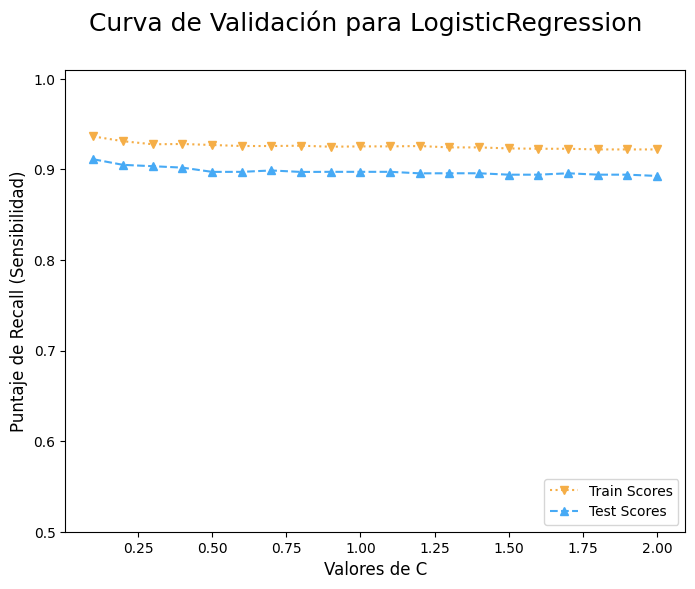

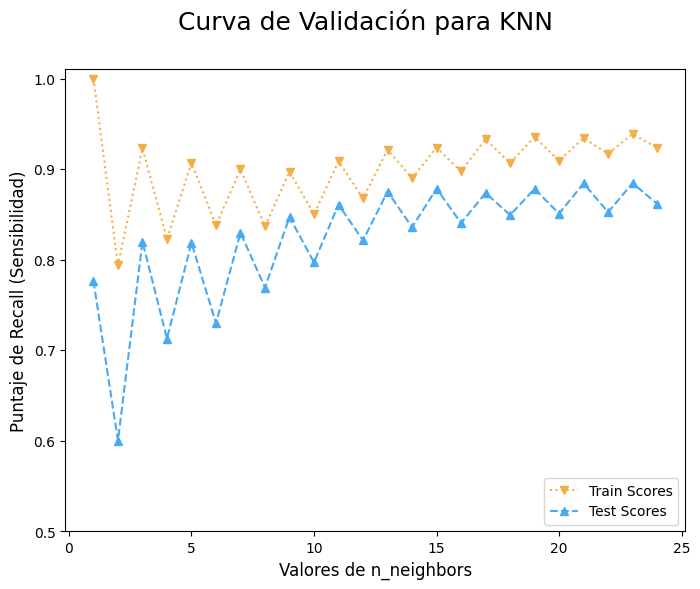

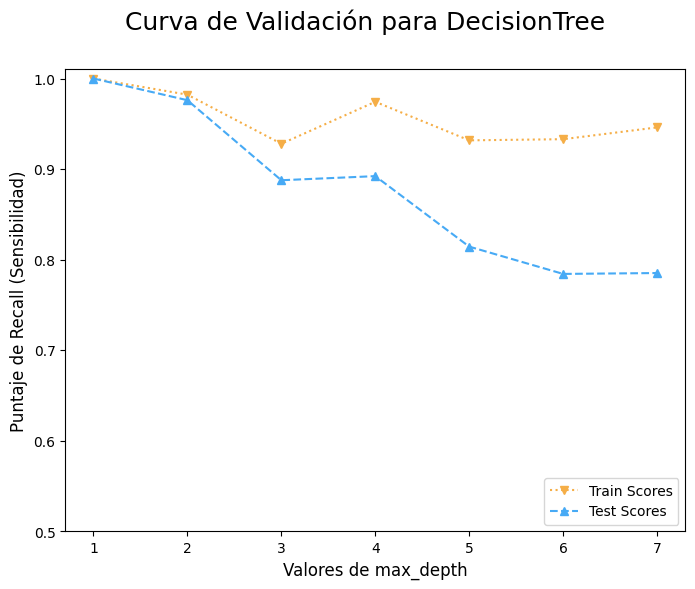

In [60]:
# Plotting validation curve of each model

for model in Models:
    PlotValidationCurve(model)

In [61]:
# Defining best hyper parameters

BestParameter_LogisticRegression = 0.1
BestParameter_KNN = 15
BestParameter_DecisionTree = 3

In [63]:
# Training models with the best hyper parameters

for model in Models:
    print(f'EMPIEZA RE-ENTRENAMIENTO :: {model}')
    global_vars[f'Model_{model}'].set_params(**{global_vars[f'Parameter_{model}']:global_vars[f'BestParameter_{model}']})
    global_vars[f'Model_{model}'].fit(train_X,train_y)
    print(f'TERMINA RE-ENTRENAMIENTO :: {model}\n')

EMPIEZA RE-ENTRENAMIENTO :: LogisticRegression
TERMINA RE-ENTRENAMIENTO :: LogisticRegression

EMPIEZA RE-ENTRENAMIENTO :: KNN
TERMINA RE-ENTRENAMIENTO :: KNN

EMPIEZA RE-ENTRENAMIENTO :: DecisionTree
TERMINA RE-ENTRENAMIENTO :: DecisionTree



# 8. Evaluación de Modelos

Utilizando el conjunto de prueba para validar los modelos con los mejores parámetros, el Modelo de Decision Tree es el que logró los mejores puntajes, pero al evaluar con más cuidado la métrica utilizada y con lo resaltado en [Data Analysis](#3-data-analysis) se entiende que la mejor regla es siempre predecir 'Yes' a cada instancia, por lo tanto este modelo sufre de underfitting porque no está aprendiendo ningún patrón sino una regla ingenua, por lo que tiene un problema de sesgo.

En el caso del Modelo KNN, pertenece a un escenario de overfitting porque en el conjunto de entrenamiento lo hace mucho mejor que en el conjunto de prueba, esto está relacionado con un problema de varianza porque pequeños cambios en los vecinos hacen que la predicción final cambie junto con el hecho de que las instancias no son linealmente separables dejando que el mínimo cambio en los valores de una instancia haga que la predicción cambie totalmente.

Dejando al Modelo Logistic Regression como el mejor modelo debido a que se comporta de igual manera tanto en el conjunto de prueba como de entrenamiento, haciendo que haya capturado y aprendido los patrones para hacer una clasificación eficiente entre clases. 

In [66]:
# Evaluaciones en el Conjunto de Prueba

EvaluateModels(Models,test_X,test_y,'Prueba')

Evaluaciones en el Conjunto de Prueba

Evluación de LogisticRegression ::
Sensibilidad (Recall) :: 0.9382716049382716

Evluación de KNN ::
Sensibilidad (Recall) :: 0.8765432098765432

Evluación de DecisionTree ::
Sensibilidad (Recall) :: 0.9876543209876543



In [67]:
# Evaluaciones en el Conjunto de Entrenamiento

EvaluateModels(Models,train_X,train_y,'Entrenamiento')

Evaluaciones en el Conjunto de Entrenamiento

Evluación de LogisticRegression ::
Sensibilidad (Recall) :: 0.9309309309309309

Evluación de KNN ::
Sensibilidad (Recall) :: 0.9279279279279279

Evluación de DecisionTree ::
Sensibilidad (Recall) :: 0.990990990990991



# Conclusiones

El usar la curva de validación para determinar como se ve modificado el bias-variance trade-off conforme el modelo se vuelve más complejo o tomar diferentes valores en sus hiperparámetros permite visualizar de mejor manera el underfit y ovefit que padece el modelo, el único problema de ello es que solo puede variar un único hiperparámetro por lo que al menos que se cuente con la certeza de que con ese hiperparámetro basta para determinar al mejor candidato entonces se vuelve una herramienta muy útil, en caso contrario se vuelve deficiente. Lo más relevante de estas curvas de validación es el valor de información que proporcionan al ver el cómo se interpretan al considerar un único valor en la curva o a englobar a todos los valores, que es aquí donde se determina si el modelo padece de sesgo o de varianza, esta interpretación que tiene permite mejorar el espacio de búsqueda de los hiperparámetros así como también tomar la decisión de complejizar el modelo en favor de capturar posibles patrones en los datos para realizar una predicción de mayor calidad.

# Referencias

* [1] Tarea 4: Error de sesgo y varianza. Flores Garrido Marisol. 
* [2] B. Ramana and N. Venkateswarlu. "ILPD (Indian Liver Patient Dataset)," UCI Machine Learning Repository, 2022. [Online]. Available: https://doi.org/10.24432/C5D02C.